In [22]:
# -*- coding: utf-8 -*-
"""
Created on 2023/04/11
Revised on 2023/05/30
 
@author: mjofre - Marc Jofre
e-mail: marc.jofre@upc.edu
Technical University of Catalonia - Universitat Politècnica de Catalunya (UPC)
"""
###########################################################################
# Seminar on Quantum Technologies for Cybersecurity: Networking and Systems
# Class
# Session 6 - Quantum Security: Networking and Systems

import os, sys, time
import numpy as np
import math
import matplotlib.pyplot as plt
from google.colab import files
import matplotlib.style
import matplotlib as mpl
#print(plt.style.available)
mpl.style.use('default')

try:
  from google.colab import files
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True) 
  pathScriptData='/content/drive/My Drive/SeminarQuantumTechnologiesCyberSecurity/ExtraScripts/'
  sys.path.append(pathScriptData)
  #!cp -r "/content/drive/My Drive/SeminarQuantumTechnologiesCyberSecurity/ExtraScripts/.ipynb" '/content/'
except:
  pass

try:  
  import qiskit
except:
  print("installing qiskit...")
  !pip install qiskit --quiet
  print("installed qiskit.")
  import qiskit

try:
  import toqito
except ImportError:
  print("installing toqito...")
  !pip install toqito --quiet
  print("installed toqito.")
  import toqito


Mounted at /content/drive


# Quantum networks - entangling capacity

Entanglement capacity: 5.411528565442651


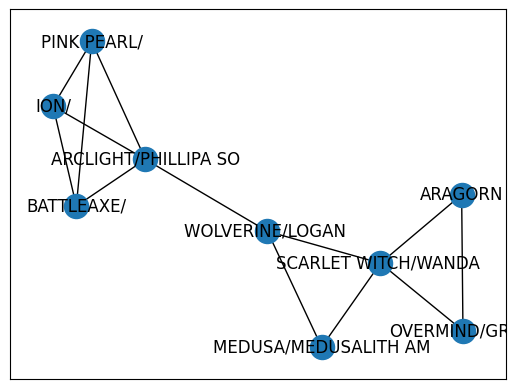

In [38]:
import pandas as pd
import networkx as nx

try:
  data = pd.read_csv(pathScriptData+'hero-network.csv')
except:
  uploaded = files.upload()
  data = pd.read_csv('hero-network.csv')

heroes = {
    'MEDUSA/MEDUSALITH AM',
    'ARCLIGHT/PHILLIPA SO',
    'WOLVERINE/LOGAN ',
    'SCARLET WITCH/WANDA ',
    'ARAGORN',
    'OVERMIND/GROM',
    'BATTLEAXE/',
    'ION/',
    'PINK PEARL/'
}

relations = data[(data.hero1.isin(heroes)) & (data.hero2.isin(heroes))]
relations = pd.DataFrame(np.sort(relations.values, axis=1), columns=relations.columns).drop_duplicates(subset=['hero1', 'hero2'])

relations.head()
#CAPTION Load the data from the csv-file

graph = nx.from_pandas_edgelist(relations, source='hero1', target='hero2')
nx.draw_networkx(graph)
#CAPTION Representing the data as a graph

matrix = nx.to_pandas_adjacency(graph, dtype=int)
#CAPTION Representing the data as a matrix

L = nx.laplacian_matrix(graph).toarray()

# Compute the eigenvalues of the Laplacian matrix
eig_values = np.linalg.eigvals(L)

# Compute the entanglement capacity
ent_cap = np.max(np.real(eig_values))

print("Entanglement capacity:", ent_cap)

# CHSH game

In [ ]:
###############################################################################
# CHSH game
# https://toqito.readthedocs.io/en/latest/tutorials.xor_quantum_value.html
import numpy as np
from toqito.nonlocal_games.xor_game import XORGame
prob_mat = np.array([[1/4, 1/4],[1/4, 1/4]]) # A matrix whose (x,y)th entry corresponds to the probability that Alice receives question x and Bob receives question y.
pred_mat = np.array([[0, 0],[0, 1]]) # A matrix whose (x,y)th  entry corresponds to the winning choice of a  and b  when Alice receives x and Bob receives y from the referee.
chsh = XORGame(prob_mat, pred_mat)
print(f'Classical strategy: {100.0*chsh.classical_value():.2f}%')
print(f'Quantum strategy: {100.0*chsh.quantum_value():.2f}%')

Classical strategy: 75.00%
Quantum strategy: 85.36%


In [ ]:
##########################################################################
# Quantum password authentication with CHSH game
# https://arxiv.org/abs/2103.01662
# https://github.com/goulov/qauth

# Other implementations: https://www.diva-portal.org/smash/get/diva2:20355/FULLTEXT01.pdf
# https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/awards/teach_me_qiskit_2018/chsh_game/CHSH%20game-tutorial.ipynb

from qiskit import BasicAer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
import secrets
from numpy import random, pi, sin, cos, arcsin, sqrt
from scipy.optimize import minimize

# quantum computer simulator backend
backend = BasicAer.get_backend('qasm_simulator')

# protocol implementation
class qauth_simulator:
  def __init__(self, N, eps, db, user_access, levels2concurr):
    self._N = N
    self._eps = eps
    self._db = db
    self._user_access = user_access
    self._levels2concurr = levels2concurr

  def chsh_predicate(self, s, t, ca, cb):
    return s*t == ca^cb

  def expected_nrwins_chsh(self, level):
    C = self._levels2concurr[level]
    return round(self._N*C)

  def play_chsh_run(self, user):
    qr = QuantumRegister(2,'q')
    cr = ClassicalRegister(2,'c')
    qc = QuantumCircuit(qr,cr)
    qc.h(qr[0])
    qc.cx(qr[0], qr[1])

    #print(qc)
    # alice lab
    a = [0.0,np.pi/2]
    s = secrets.randbits(1)
    qc.ry(a[s], qc.qregs[0][0])
    
    # bob lab
    b= [np.pi/4,-np.pi/4]
    t = secrets.randbits(1)
    qc.ry(b[t], qc.qregs[0][1])

    #print(qc)
    # run the circuit -- "announce phase"
    qc.measure(qc.qregs[0][0], qc.cregs[0][0])
    qc.measure(qc.qregs[0][1], qc.cregs[0][1])
    job = execute(qc, backend, shots=int(1))
    res = job.result().get_counts()

    # reads the result of the measurements of the quantum system
    for outcomes in res.keys():
      out = outcomes
    # converts the result of the measurements contained in the classical register as string '00', '01', '10', '11',
    # which are the answers of Alice(a) and Bob (b), from a 'string' type  to 'integer' type 
    if(out == '00'):
      ca = 0
      cb = 0
    elif(out == '01'):
      ca = 1
      cb = 0    
    elif(out == '10'):
      ca = 0
      cb = 1
    else: #(out == '11'):
      ca = 1
      cb = 1
    
    return s, t, ca, cb

  def play_all_chsh(self, user):
    nr_wins = 0
    for iIterN in range(self._N):
      s, t, ca, cb = self.play_chsh_run(user)
      nr_wins += self.chsh_predicate(s, t, ca, cb)
    return nr_wins

  def authorize(self, user):
    nr_wins = self.play_all_chsh(user)
    user_level = self._user_access[user]
    expected_wins = self.expected_nrwins_chsh(user_level)
    print("runs won:", nr_wins)
    print("expected:", expected_wins)
    print("epsilon is:", self._eps)
    # authorizer checks if the number of wins is as predicted (up to eps)
    if (expected_wins - nr_wins) <= self._eps:
      #print(self._db[:user_level])
      print(f'Access level acquired: {self._db[user_level-1]}')
    else:
      print("FORBIDDEN: failed to win to the level requested")
      iLevelMax=0
      for iLevel in range(0,4,1):
        if ((self.expected_nrwins_chsh(iLevel+1) - nr_wins) <= self._eps):
          iLevelMax=iLevel
      print(f'Access level acquired: {self._db[iLevelMax]}')

if __name__ == "__main__":
  # lambda = 128, l = 4
  N = 100#16384 # number of iterations
  epsilon = int(sqrt(N)/2)#1536 # error interval allowed
  db = ["dblevel1", "dblevel2", "dblevel3", "dblevel4"]
  levels2concurr = {1: 0.25,2: 0.5,3: 0.75,4: 1} # Numeric success levels for access
  user_access = {"user1": 1, "user2": 2,"user3": 3,"user4": 4} # Levels of access of users. so user 1 has the lowest access level (only up to level 1), user 2 has access up to level 2, and so on

  q = qauth_simulator(N, epsilon, db, user_access, levels2concurr)
  q.authorize('user1')
  q.authorize('user2')
  q.authorize('user3')
  q.authorize('user4')

runs won: 85
expected: 25
epsilon is: 5
Access level acquired: dblevel1
runs won: 87
expected: 50
epsilon is: 5
Access level acquired: dblevel2
runs won: 86
expected: 75
epsilon is: 5
Access level acquired: dblevel3
runs won: 89
expected: 100
epsilon is: 5
FORBIDDEN: failed to win to the level requested
Access level acquired: dblevel3


# Quantum Internet

# Wrap-up of Probability errors and Fidelity

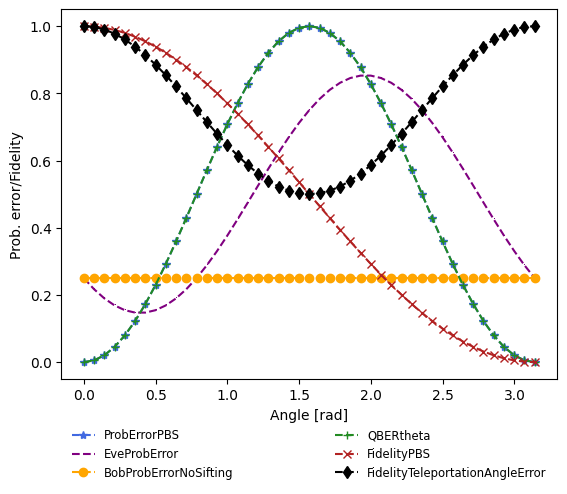

In [ ]:
##############################################################################
# Relation of Probability errors, QBER, Fidelities with the the rotation of the measurement basis \theta
NcalcAngle=45
MaxAngle=np.pi
AnglesScan=np.linspace(0,MaxAngle,NcalcAngle)

ProbErrorPBS=1.0-np.cos(AnglesScan)**2
EveProbError=0.25*((1.0-np.cos(2.0*AnglesScan))+(1.0-np.sin(2.0*AnglesScan))) # Error probability when Eve is randomly changing basis (it is minimized to 14.64% when theta=np.pi/8 - Breidbart basis)
BobProbErrorNoSifting=0.25*((1.0-np.cos(2.0*AnglesScan)**2)+(1.0-np.sin(2.0*AnglesScan)**2)) # Error probability when Bob is randomly changes basis (before key sifting)
QBERtheta=1.0-np.cos(AnglesScan)**2 # Error probability equivalent to Bob when doing sifting
FidelityPBS=1.0-np.sin(AnglesScan/2.0)**2# Angle is half, because at np.pi/2.0 its like at half place between the two states
FidelityTeleportationAngleError=1.0-ProbErrorPBS/2.0
# Fidelity cascaded devices F=Fi**N
# Fidelity in terms of coincidences F=RatioRc/(1.0+RatioRc), where RatioRc is the ratio of coincidences between RcParallel/RcOrthogonal (Rc coincidence rate)

plt.figure()
line1,=plt.plot(AnglesScan,ProbErrorPBS,'royalblue',linestyle='dashed',marker='*')
line2,=plt.plot(AnglesScan,EveProbError,'purple',linestyle='dashed',marker=',')
line3,=plt.plot(AnglesScan,BobProbErrorNoSifting,'orange',linestyle='dashed',marker='o')
line4,=plt.plot(AnglesScan,QBERtheta,'forestgreen',linestyle='dashed',marker='+')
line5,=plt.plot(AnglesScan,FidelityPBS,'firebrick',linestyle='dashed',marker='x')
line6,=plt.plot(AnglesScan,FidelityTeleportationAngleError,'black',linestyle='dashed',marker='d')
plt.legend((line1, line2, line3, line4, line5, line6), ('ProbErrorPBS','EveProbError','BobProbErrorNoSifting','QBERtheta','FidelityPBS','FidelityTeleportationAngleError'),bbox_to_anchor=(0, -0.3, 1, 0), loc="lower left", mode="expand", ncol=2,shadow = False, fancybox = False, frameon = False, fontsize='small')# 'best'
plt.xlabel('Angle [rad]',color='k')
plt.ylabel('Prob. error/Fidelity',color='k')
plt.show()

####################################################
# Relevant transmittivity/loss related equations:
# Rr=eta Rs # where eta is the transmissivity as eta \leq 1 and proportional to np.exp(-att Distance), where att is the attenuation att\geq 0.
# dBatt=dBLoss/Km*L(Km)
# dBatt=-10 log10(eta)
# ProbabilityPhotonLoss=1-eta=1-np.exp(-Distance/L0), where dBLoss/Km * L0=-10 log10(1/e)

####################################################
# Relevant trigonometric relations
# cos(theta)**2+sin(theta)**2=1
# sin(theta)**2=0.5*(1-cos(2theta))
# cos(theta)**2=0.5*(1+cos(2theta))